In [51]:
import numpy as np
import matplotlib.pyplot as plt

In [64]:
gamma = 1.4
L = 1
# Time-Stepping Parameters
CFL     = 0.5   # Courant number
t_final = 0.2

In [53]:
# Function to convert conserved to primitive variables
def cons_to_prim(U):
    rho = U[...,0]
    u   = U[...,1] / rho
    E   = U[...,2]
    p   = (gamma - 1) * (E - 0.5 * rho * u**2)
    return rho, u, p

In [54]:
# HLL Riemann Solver
def HLL_flux(UL, UR):
    # Convert to primitive variables
    rhoL, uL, pL = cons_to_prim(UL)
    rhoR, uR, pR = cons_to_prim(UR)

    # Shorthands for energy
    EL = UL[2]
    ER = UR[2]

    # Compute speed of sound
    cL = np.sqrt(gamma * pL / rhoL)
    cR = np.sqrt(gamma * pR / rhoR)

    # Estimate wave speeds
    SL = min(uL - cL, uR - cR)
    SR = max(uL + cL, uR + cR)

    # Compute fluxes for left and right states
    FL = np.array([
        rhoL * uL,
        rhoL * uL**2 + pL,
        uL   * (EL + pL)
    ])

    FR = np.array([
        rhoR * uR,
        rhoR * uR**2 + pR,
        uR   * (ER + pR)
    ])

    # Compute HLL flux
    if SL > 0:
        return FL
    elif SL <= 0 and SR >= 0:
        return (SR * FL - SL * FR + SL * SR * (UR - UL)) / (SR - SL)
    else:
        return FR

In [55]:
def bruh(N):
	# Physical Parameters
	t       = 0.0   # Initial time

	# Computational Domain
	#N  = 100    # Number of cells
	dx = L / N  # Cell width
	x  = np.linspace(0.5*dx, L - 0.5*dx, N)  # Cell centers

	# Initialize Conserved Variables [rho, rho*u, E]
	U = np.zeros((N, 3))

	# Initial Conditions
	rho0 = np.where(x < 0.5, 1.0, 0.125)          # Density
	u0   = np.zeros(N)                            # Velocity
	p0   = np.where(x < 0.5, 1.0, 0.1)            # Pressure
	E0   = p0 / (gamma - 1) + 0.5 * rho0 * u0**2  # Total Energy

	U[:, 0] = rho0       # Density
	U[:, 1] = rho0 * u0  # Momentum
	U[:, 2] = E0         # Energy

	# Keep the history of the run
	Ts = [t]
	Us = [U.copy()]

	# Time-stepping loop
	while t < t_final:
		# Convert to primitive variables
		rho, u, p = cons_to_prim(U)

		# Compute time step
		cs   = np.sqrt(gamma * p / rho)
		cmax = np.max(np.abs(u) + cs)
		dt   = CFL * dx / cmax
		if t + dt > t_final:
			dt = t_final - t

		# Compute fluxes at interfaces
		flux = np.zeros((N+1, 3))
		for i in range(1,N):
			flux[i] = HLL_flux(U[i-1], U[i])

		# Boundary conditions on flux
		#flux = np.pad(flux, (1, 1), 'wrap')
		flux[ 0] = flux[1]
		flux[-1] = flux[-2]
		# Update conserved variables
		U -= (dt / dx) * (flux[1:] - flux[:-1])

		# Update time and add to history
		t += dt
		Ts.append(t)
		Us.append(U.copy())

	return Ts, Us, x

In [56]:
from scipy.optimize import fsolve
def get_sod_solution(x, t_plot=0.2, rho_L=1, u_L=0, P_L=1, rho_R=0.125, u_R=0, P_R=0.1, gamma=1.4, x_diaphragm=0.5, **kwargs):
    def f_P_star(P_star, P_L, rho_L, u_L, c_L, P_R, rho_R, u_R, c_R, gamma, **kwargs):
        term1 = (P_star / P_L)**((gamma - 1) / (2 * gamma))
        u_rarefaction_side = u_L + (2 * c_L / (gamma - 1)) * (1 - term1)

        u_shock_side = u_R + (P_star - P_R) * np.sqrt((2 / ((gamma + 1) * rho_R)) / (P_star + (gamma - 1) / (gamma + 1) * P_R))

        return u_rarefaction_side - u_shock_side
    c_L = np.sqrt(gamma * P_L / rho_L)
    c_R = np.sqrt(gamma * P_R / rho_R)

    P_star_guess = 0.5 * (P_L + P_R)
    P_star = fsolve(f_P_star, P_star_guess, args=(P_L, rho_L, u_L, c_L, P_R, rho_R, u_R, c_R, gamma))[0]

    u_star = u_L + (2 * c_L / (gamma - 1)) * (1 - (P_star / P_L)**((gamma - 1) / (2 * gamma)))

    rho_2 = rho_L * (P_star / P_L)**(1 / gamma)
    c_2 = np.sqrt(gamma * P_star / rho_2)

    rho_4 = rho_R * ((P_star / P_R) * (gamma + 1) + (gamma - 1)) / ((P_star / P_R) * (gamma - 1) + (gamma + 1))

    S_RH = u_L - c_L
    S_RF = u_star - c_2
    S_CD = u_star
    S_S = u_R + c_R * np.sqrt(((gamma + 1) / (2 * gamma)) * (P_star / P_R) + (gamma - 1) / (2 * gamma))

    X_RH = x_diaphragm + S_RH * t_plot
    X_RF = x_diaphragm + S_RF * t_plot
    X_CD = x_diaphragm + S_CD * t_plot
    X_S = x_diaphragm + S_S * t_plot

    rho = np.zeros_like(x)
    P = np.zeros_like(x)
    u = np.zeros_like(x)

    for i, xi in enumerate(x):
        if xi < X_RH:
            rho[i] = rho_L
            P[i] = P_L
            u[i] = u_L
        elif X_RH <= xi < X_RF:
            u_i = (2 / (gamma + 1)) * (c_L + ((xi - x_diaphragm) / t_plot) + (u_L * (gamma - 1) / 2))
            c_i = c_L - ((gamma - 1) / 2) * (u_i - u_L)
            P_i = P_L * (c_i / c_L)**(2 * gamma / (gamma - 1))
            rho_i = rho_L * (c_i / c_L)**(2 / (gamma - 1))
            rho[i] = rho_i
            P[i] = P_i
            u[i] = u_i
        elif X_RF <= xi < X_CD:
            rho[i] = rho_2
            P[i] = P_star
            u[i] = u_star
        elif X_CD <= xi < X_S:
            rho[i] = rho_4
            P[i] = P_star
            u[i] = u_star
        else:
            rho[i] = rho_R
            P[i] = P_R
            u[i] = u_R

    return np.array(rho), np.array(u), np.array(P)

In [ ]:
def calc_MSE(U, X, dx):
    def rms(compu_data, analytic_data, dx):
        numerator = np.sum(np.abs(compu_data - analytic_data))
        return (numerator) ** 2
    
    grid_solution = U
    
    rho_numeric = grid_solution[0]

    u_numeric = grid_solution[1]
    P_numeric = grid_solution[2]
    rho_analytic, u_analytic, P_analytic = get_sod_solution(X)

    rho_MSE = rms(rho_numeric, rho_analytic, dx) 
    u_MSE = rms(u_numeric, u_analytic, dx) 
    P_MSE = rms(P_numeric, P_analytic, dx) 

    return np.sqrt(rho_MSE + u_MSE + P_MSE)

In [68]:
MSE = []
NX = [2 ** n for n in range(4, 8)]
for n in NX:
    print(n)
    _, Us, x = bruh(n)
    prim = np.array(cons_to_prim(Us[-1]))
    #rho_ana, u_ana, p_ana = get_sod_solution(x)

    MSE.append(calc_MSE(prim, x, L/n))

16
32
64
128


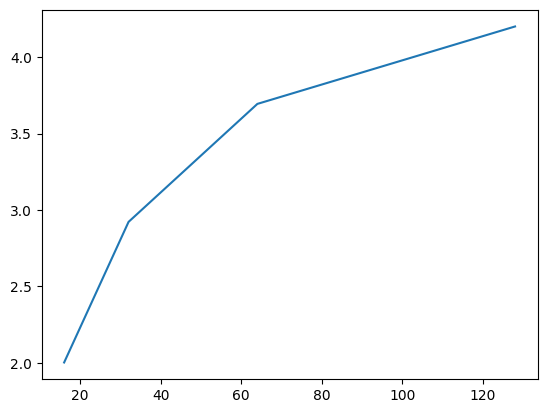

In [73]:
plt.plot(NX, MSE)

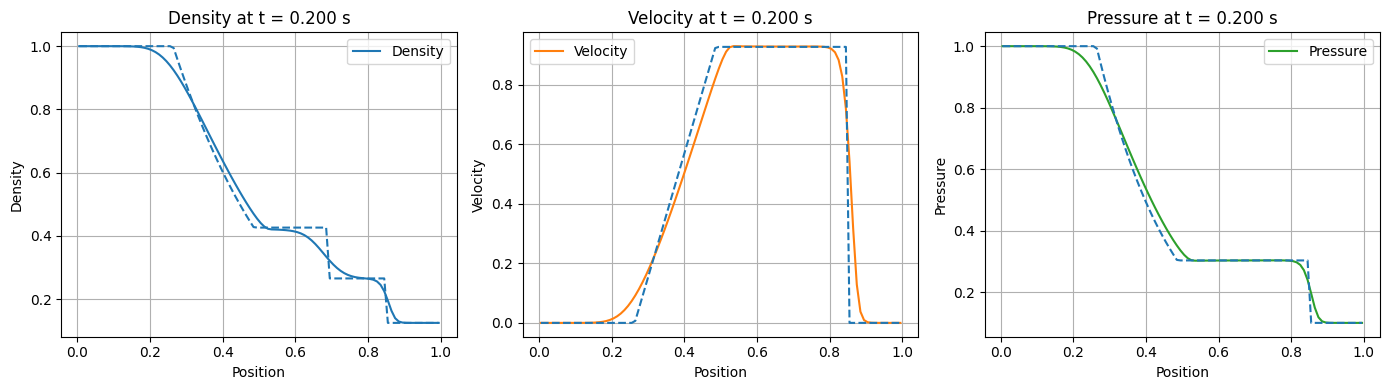

In [72]:
Ts, Us, x = bruh(100)
# Visualization of Results
rho, u, p = cons_to_prim(Us[-1])

ana = get_sod_solution(x)

plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.plot(x, rho,       label='Density', color='C0')
plt.plot(x, ana[0], '--')
plt.xlabel('Position')
plt.ylabel('Density')
plt.title('Density at t = {:.3f} s'.format(t_final))
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(x, u,       label='Velocity', color='C1')
plt.plot(x, ana[1], '--')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Velocity at t = {:.3f} s'.format(t_final))
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(x, p,       label='Pressure', color='C2')
plt.plot(x, ana[2], '--')
plt.xlabel('Position')
plt.ylabel('Pressure')
plt.title('Pressure at t = {:.3f} s'.format(t_final))
plt.legend()
plt.grid()

plt.tight_layout()